# Phase space tomography

Primer for using phase space tomography tool

In [1]:
from pstomo.preprocess import Preprocess
import numpy as np
import matplotlib.pyplot as plt
from pstomo.tomo_plot import Plot
from pstomo.reconstruct import Reconstruct
from pstomo.track import Lattice, Model, Track
import pickle

Import sinograms measured in AWAKE. 

In [2]:
%autoreload
with open('quad_scan_emit', 'rb') as f:
    data = pickle.load(f)
ks = np.round(np.linspace(-40, 40, 20),2)

pixel_size = 0.04
# relativistic gamma
gamma_rel = 36.21733068245433

# im_ax2 = image.shape[1]
def center_projection(im_ax1, ax_range, proj_x):
        x_n = im_ax1-np.average(im_ax1, weights = proj_x)
        x_n_2 = np.linspace(ax_range[0], ax_range[1], len(x_n))
        y_n = np.interp(x_n_2, x_n, proj_x)
        return x_n_2, y_n

projections_x = [] 
projections_y = [] 

ax_range = [-2, 2]
for count, k in enumerate(ks):
    image = data['image_{}'.format(k)]
    im_ax2 = (np.arange(image.shape[1])-image.shape[1]//2)*pixel_size
    im_ax1 = (np.arange(image.shape[2])-image.shape[2]//2)*pixel_size
    projs_x = []
    projs_y = []
    for ind in range(image.shape[0]):

        image[ind,:,:] = np.flipud(image[ind,:,:])
        if (np.isnan(np.sum(image[ind,:,:]))==False):
            proj_y = np.sum(image[ind,:,:], axis=1)
            proj_x = np.sum(image[ind,:,:], axis=0)
            proj_x = center_projection(im_ax1, ax_range,proj_x)
            proj_y = center_projection(im_ax2, ax_range, proj_y)
            projs_x.append(list(proj_x))
            projs_y.append(list(proj_y))
        projs_x_arr = np.array(projs_x)
        projs_y_arr = np.array(projs_y)
    x, meanx = np.mean(projs_x_arr, axis=0)
    y, meany = np.mean(projs_y_arr, axis=0)
    projections_x.append(list(meanx))
    projections_y.append(list(meany))

projections_x = np.array(projections_x)
projections_y = np.array(projections_y)
pixel_size_x = x[1]-x[0]
pixel_size_y = y[1]-y[0]

Now it is time to preprocess the data to make them ready for tomography

In [3]:
%autoreload
sequence = {'quad':[0.0708,10], 'drift':[0.831693]}

processx = Preprocess(projections_x, ks, sequence, pixel_size_x, plane='x', norm=[-0.2, 0.85])
processy = Preprocess(projections_y, ks, sequence, pixel_size_y, plane='y', norm=[-0.2, 1.19])


the process instance is used as input for reconstruction

In [4]:
%autoreload
recx = Reconstruct(processx)
recy = Reconstruct(processy)

dist_x = recx.MLEM(200)
dist_y = recy.MLEM(200)




c:\Users\vbencini\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


In [5]:
%autoreload
pl = Plot(processx, processy, dist_x, dist_y)
# Plot scaled sinograms

# pl.plot_sino_scale()
pl.plot_reconstructed()
# pl.plot_sino()


(<Figure size 700x800 with 2 Axes>,
 array([<AxesSubplot:title={'center':'x plane'}, xlabel='x (mm)', ylabel="x' (mrad)">,
        <AxesSubplot:title={'center':'y plane'}, xlabel='y (mm)', ylabel="y' (mrad)">],
       dtype=object))

Let's generate a distribution from the reconstructed images

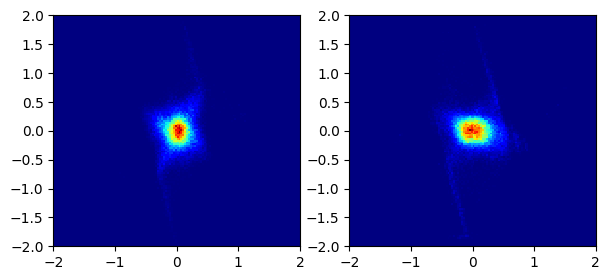

In [6]:
dist_x_part = utils.gen_dist(dist_x, 10000, processx.x_new)
dist_y_part = utils.gen_dist(dist_y, 10000, processy.x_new)


dist_x_part_unnorm = utils.apply(processx.Vi,dist_x_part)
dist_y_part_unnorm = utils.apply(processy.Vi,dist_y_part)

dist = np.hstack((dist_x_part_unnorm, dist_y_part_unnorm))

fig, axs = plt.subplots(1, 2, figsize= (7, 3))
_ = axs[0].hist2d(dist[:,0], dist[:,1], bins = 128, range=[[-2, 2],[-2, 2]])
_ = axs[1].hist2d(dist[:,2], dist[:,3], bins = 128, range=[[-2, 2],[-2, 2]])
plt.show()

Text(0, 0.5, 'x (mm)')

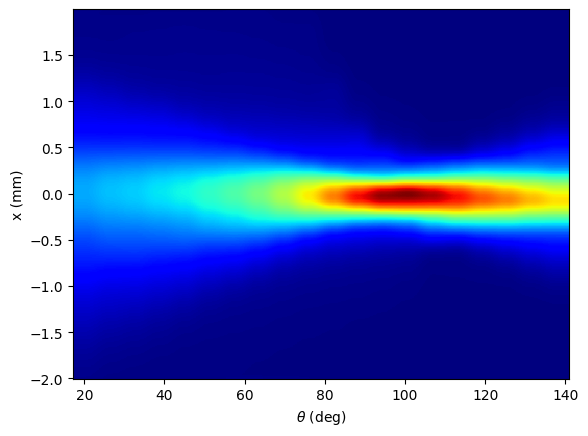

In [7]:
projections,_ = utils.track(dist_x_part_unnorm, processx.thetas, 'x', processx.x_new, processx.Vi, n_bins=128)
proj_trackx = utils.norm_image(projections)
plt.imshow(proj_trackx, origin = 'lower',extent=[processx.thetas[0], processx.thetas[-1], processx.x_new[0], processx.x_new[-1]],  aspect = 'auto', vmax=1)
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('x (mm')


plt.figure()
plt.imshow(utils.norm_image(processx.unscaled_projections).T, origin = 'lower',extent=[processx.thetas[0], processx.thetas[-1], processx.x_new[0], processx.x_new[-1]],  aspect = 'auto', vmax = 1)
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('x (mm)')


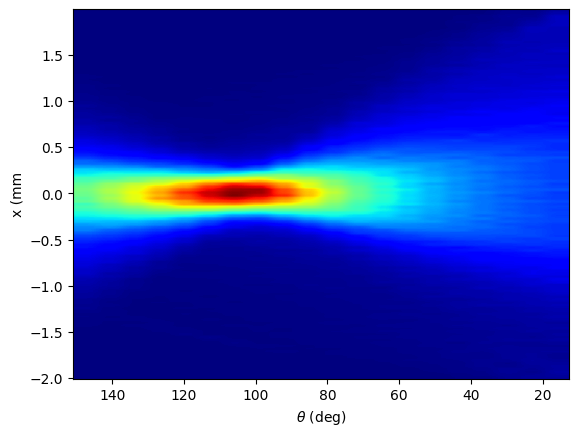

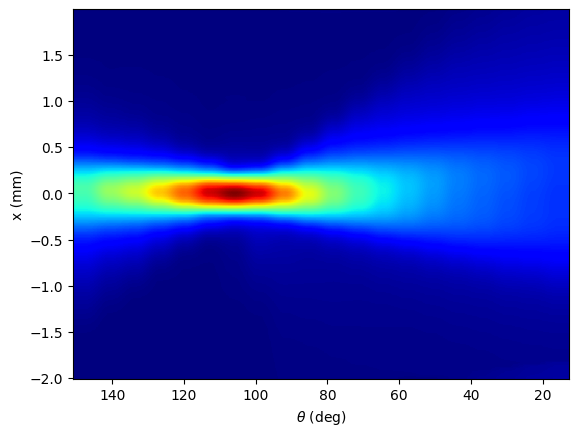

In [9]:
projections,_ = utils.track(dist_y_part_unnorm, processy.thetas, 'y', processy.x_new, processy.Vi, n_bins=128)
proj_tracky = utils.norm_image(projections)
plt.imshow(proj_tracky, origin = 'lower',extent=[processy.thetas[0], processy.thetas[-1], processy.x_new[0], processy.x_new[-1]],  aspect = 'auto', vmax=1)
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('x (mm')

plt.figure()
plt.imshow(utils.norm_image(processy.unscaled_projections).T, origin = 'lower',extent=[processy.thetas[0], processy.thetas[-1], processy.x_new[0], processy.x_new[-1]],  aspect = 'auto', vmax = 1)
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('x (mm)')


# Compare reconstruction methods

In [10]:
%autoreload

twiss_qs_x = recx.QuadScanRec()
twiss_qs_y = recy.QuadScanRec()

covx = twiss_qs_x[0]*np.array([[twiss_qs_x[2], -twiss_qs_x[1]],[-twiss_qs_x[1], twiss_qs_x[3]]])
covy = twiss_qs_y[0]*np.array([[twiss_qs_y[2], -twiss_qs_y[1]],[-twiss_qs_y[1], twiss_qs_y[3]]])
# Generate distribution with same Twiss parameters
dist_qs_x = np.random.multivariate_normal((0,0), covx, size=10000)
dist_qs_y = np.random.multivariate_normal((0,0), covy, size=10000)

dist_qs = np.hstack((dist_qs_x, dist_qs_y))

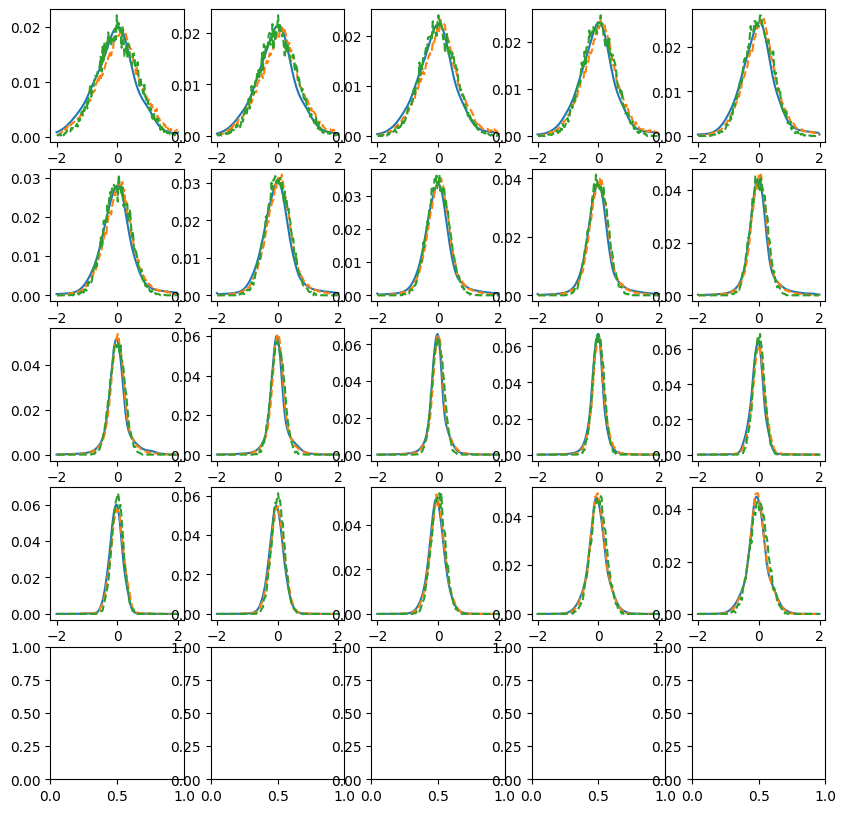

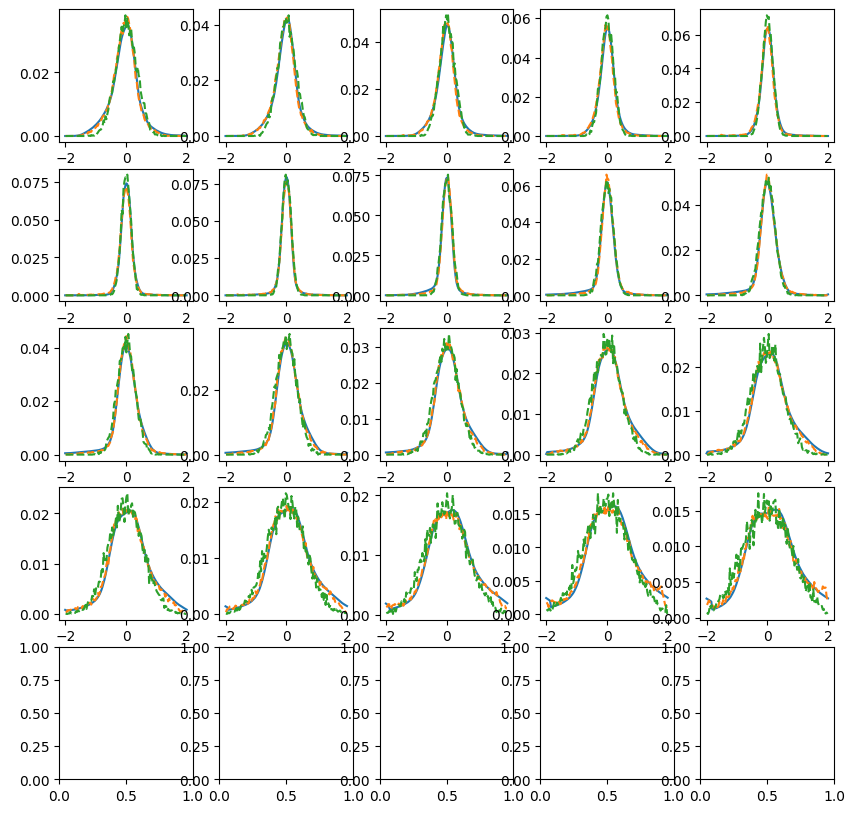

In [11]:
# ph = utils.get_theta_norm(Vi, k, 'x')
%autoreload
figx, axsx = plt.subplots(5,5, figsize = (10, 10))
figy, axsy = plt.subplots(5,5, figsize = (10, 10))
sigmasg_x = []
sigmasg_y = []
sigmas_rec_x = []
sigmas_rec_y = []
axsx = axsx.flatten()[:21]
axsy = axsy.flatten()[:21]

for p in range(len(ks)):
    ind = p
    seq = {'quad':[0.0708,recx.ks[ind]], 'drift':[0.831693]}
    tr = Track(seq, dist)
    tr.track()
    dist_out = tr.dist_out
    tr.dist = dist_qs
    tr.track()
    dist_qs_out = tr.dist_out

    projectionx, edgesx = np.histogram(dist_out[:,0], range=(processx.x_new[0], processx.x_new[-1]), bins=128)
    projectiongx, edgesgx = np.histogram(dist_qs_out[:,0], range=(processx.x_new[0], processx.x_new[-1]), bins=128)
    projectionx = projectionx/np.sum(projectionx)
    projectiongx = projectiongx/np.sum(projectiongx)

    projectiony, edgesy = np.histogram(dist_out[:,2], range=(processy.x_new[0], processy.x_new[-1]), bins=128)
    projectiongy, edgesgy = np.histogram(dist_qs_out[:,2], range=(processy.x_new[0], processy.x_new[-1]), bins=128)
    projectiony = projectiony/np.sum(projectiony)
    projectiongy = projectiongy/np.sum(projectiongy)

    axsx[p].plot(processx.x_new, processx.unscaled_projections[ind,:]/np.sum(processx.unscaled_projections[ind,:]))
    axsx[p].plot(utils.get_bin_centers(edgesx), projectionx, linestyle = '--')
    axsx[p].plot(utils.get_bin_centers(edgesgx), projectiongx, linestyle = '--')

    axsy[p].plot(processy.x_new, processy.unscaled_projections[ind,:]/np.sum(processy.unscaled_projections[ind,:]))
    axsy[p].plot(utils.get_bin_centers(edgesy), projectiony, linestyle = '--')
    axsy[p].plot(utils.get_bin_centers(edgesgy), projectiongy, linestyle = '--')

    coeffsx,_ = utils.gaussian_profile_fit(x, projections_x[p,:])
    sigmas_rec_x.append(coeffsx[2])
    sigmasg_x.append(np.std(dist_qs_out[:,0]))
    coeffsy,_ = utils.gaussian_profile_fit(y, projections_y[p,:])
    sigmas_rec_y.append(coeffsy[2])
    sigmasg_y.append(np.std(dist_qs_out[:,2]))


# figx.tight_layout()
# plt.plot(processx.x_new, processx.unscaled_projections[5,:])
# plt.plot(processx.x_new, processx.unscaled_projections[10,:])
plt.show()

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))
axs[0].plot(recx.ks, recx.sigmas, label = 'Measured')
axs[0].plot(recx.ks, np.array(sigmasg_x), label='Quad Scan')
axs[0].plot(recx.ks, np.array(sigmas_rec_x), label='Tomography')
axs[0].set_xlabel('$k$ $(1/m^2)$')
axs[0].set_ylabel('$\sigma_x$ $(mm)$')
axs[1].plot(recx.ks, recy.sigmas, label = 'Measured')
axs[1].plot(recx.ks, np.array(sigmasg_y), label='Quad Scan')
axs[1].plot(recx.ks, np.array(sigmas_rec_y), label='Tomography')
axs[1].set_xlabel('$k$ $(1/m^2)$')
axs[1].set_ylabel('$\sigma_y$ $(mm)$')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

In [13]:
# Now let's backtrack the distribution to the entrance of the line

def backtrack_rec_dist(dist_4d):
    dist_4d_bt = dist_4d.copy()

    dist_4d_bt[:,1] = -dist_4d_bt[:,1]
    dist_4d_bt[:,3] = -dist_4d_bt[:,3]

    seq = {'drift':[0.768073-0.0708/2]}
    tr = Track(seq, dist_4d_bt)
    tr.track()
    dist_4d_rec_point = tr.dist_out
    dist_4d_rec_point[:,1] = -dist_4d_rec_point[:,1]
    dist_4d_rec_point[:,3] = -dist_4d_rec_point[:,3]
    return dist_4d_rec_point

dist_bt = backtrack_rec_dist(dist)

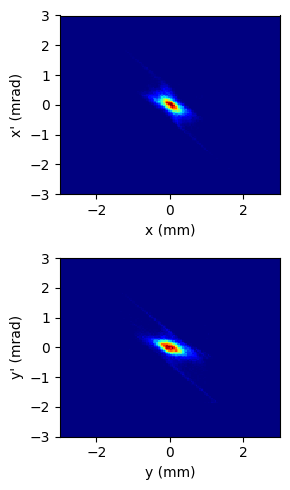

In [14]:
fig, axs = plt.subplots(2, 1, figsize= (3, 5))
_ = axs[0].hist2d(dist_bt[:,0], dist_bt[:,1], bins = 128, range=[[-3, 3],[-3, 3]])
_ = axs[1].hist2d(dist_bt[:,2], dist_bt[:,3], bins = 128, range=[[-3, 3],[-3, 3]])
axs[0].set_xlabel('x (mm)')
axs[0].set_ylabel('x\' (mrad)')
axs[1].set_xlabel('y (mm)')
axs[1].set_ylabel('y\' (mrad)')
plt.tight_layout()
plt.show()


In [15]:
dpp = 5e-4 #delta_p/p0
bunch_length = 1.2e-3 #m

# Generate longitudinal distribution

cov = np.array([[ bunch_length**2, 0],[0,dpp**2]])

p_bl = np.random.multivariate_normal((0,0), cov, size=int(0.8*dist.shape[0]))


dist_dict = {}
dist_dict['x'] = dist_bt[:,0]*1e-3
dist_dict['px'] = dist_bt[:,1]*1e-3
dist_dict['y'] = dist_bt[:,2]*1e-3
dist_dict['py'] = dist_bt[:,3]*1e-3
dist_dict['t'] = p_bl[:,0]
dist_dict['pt'] = p_bl[:,1]


In [16]:
# Export distribution in madx format
export_to = '../../old-line/awake-matching-all-master/rec_dist_example'
with open(export_to, 'wb') as f:
    pickle.dump(dist_dict, f)
    
